In [1]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100)     
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None) 


# Text Preprocessing

In [3]:

df = pd.read_csv('08_stemmed.csv')
df1 = pd.read_csv('2700_stemmed.csv')
df = pd.concat([df, df1])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8344 entries, 0 to 2781
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      8344 non-null   int64  
 1   created_at               8344 non-null   object 
 2   favorite_count           8344 non-null   int64  
 3   full_text                8344 non-null   object 
 4   id_str                   8344 non-null   int64  
 5   image_url                2141 non-null   object 
 6   in_reply_to_screen_name  4202 non-null   object 
 7   lang                     8344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              8344 non-null   int64  
 10  reply_count              8344 non-null   int64  
 11  retweet_count            8344 non-null   int64  
 12  tweet_url                8344 non-null   object 
 13  user_id_str              8344 non-null   int64  
 14  username                 2782

In [4]:
df.duplicated().sum()

0

In [5]:
df['label'].value_counts()

label
positif    3856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64

In [6]:
df_negatif = df[df['label'] == 'positif']
df_lainnya = df[df['label'] != 'positif']

df_negatif_tersisa = df_negatif.sample(n=len(df_negatif) - 1000, random_state=42)

df = pd.concat([df_negatif_tersisa, df_lainnya], ignore_index=True)

print(df['label'].value_counts())


label
positif    2856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64


In [6]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

mention_whitelist = ['prabowo']

normalisasi_kata = {
    'gak': 'tidak',
    'ga': 'tidak',
    'yg': 'yang',
    'utk': 'untuk',
    'dgn': 'dengan',
    'apik': 'baik',
    'sdh': 'sudah',
    'krn': 'karena',
    'apik': 'bagus',
    'tdk': 'tidak',
    'klo': 'kalo',
    'sbg': 'sebagai',
    'gue': 'aku',
    'dlm': 'dalam',
    'jgn': 'jangan',
    'jkw': 'jokowi',
    'org': 'orang',
    'nggak': 'tidak',
    'aja': '',
    'amp': '',
    'nya': '',
    'ya': '',
    'gitu': '',
    'loh': '',
    'dong': '',
    'sih': '',
    'deh': '',
    'nih': '',
    'kok': '',
}

def preprocessing(text):
    text = re.sub(r'@(\w+)', lambda m: m.group() if m.group(1).lower() in mention_whitelist else '', text)

    text = re.sub(r'http\S+|www\S+|<.*?>|#', ' ', text)
    
    text = re.sub(r'<.*?>', '', text)

    # non-huruf (angka, simbol)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    text = text.lower()

    # Tokenisasi
    tokens = word_tokenize(text)

    # Normalisasi kata informal
    tokens = [normalisasi_kata.get(word, word) for word in tokens]

    tokens = [word for word in tokens if word not in stop_words and len(word) > 2 and word != '']

    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)


In [ ]:
def apply_with_progress(df, func, column, new_column, step=50):
    result = []
    for i, text in enumerate(df[column]):
        result.append(func(text))
        if (i + 1) % step == 0 or (i + 1) == len(df):
            print(f"Processed {i + 1}/{len(df)} rows")
    df[new_column] = result
    return df

df = apply_with_progress(df, preprocessing, 'full_text', 'text_processed')
df.head()


Processed 50/7344 rows
Processed 100/7344 rows
Processed 150/7344 rows
Processed 200/7344 rows
Processed 250/7344 rows
Processed 300/7344 rows
Processed 350/7344 rows
Processed 400/7344 rows
Processed 450/7344 rows
Processed 500/7344 rows
Processed 550/7344 rows
Processed 600/7344 rows
Processed 650/7344 rows
Processed 700/7344 rows
Processed 750/7344 rows
Processed 800/7344 rows
Processed 850/7344 rows
Processed 900/7344 rows
Processed 950/7344 rows
Processed 1000/7344 rows
Processed 1050/7344 rows
Processed 1100/7344 rows
Processed 1150/7344 rows
Processed 1200/7344 rows
Processed 1250/7344 rows
Processed 1300/7344 rows
Processed 1350/7344 rows
Processed 1400/7344 rows
Processed 1450/7344 rows
Processed 1500/7344 rows
Processed 1550/7344 rows
Processed 1600/7344 rows
Processed 1650/7344 rows
Processed 1700/7344 rows
Processed 1750/7344 rows
Processed 1800/7344 rows
Processed 1850/7344 rows
Processed 1900/7344 rows
Processed 1950/7344 rows
Processed 2000/7344 rows
Processed 2050/7344 

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,text_processed,label_num
0,1881368022864314877,Mon Jan 20 15:47:45 +0000 2025,0,Rasa puas publik jadi bukti solid kinerja Prabowo-Gibran selama 100 hari #KinerjaPrabowoTerbukti,1881368022864314877,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/1881368022864314877,1698922885946220544,NaN,positif,puas publik bukti solid kinerja prabowo gibran kinerjaprabowoterbukti,1
1,1883295764820148727,Sat Jan 25 23:27:54 +0000 2025,0,Menjelang genap 100 hari pemerintahan Prabowo-Gibran Tingkat kepuasan publik terhadap kinerja Prabowo-Gibran diberbagai sektor menurut salah satu lembaga survey mencapai 80 9 persen. Lalu Bagaimana mencermati 100 hari perjalanan kebijakan pemerintahan Prabowo - Gibran di sektor https://t.co/RhL4R0Xfev,1883295764820148727,https://pbs.twimg.com/media/GiLPSURbkAAZB-6.jpg,NaN,in,NaN,0,0,0,https://x.com/undefined/status/1883295764820148727,121640063,NaN,positif,menjelang genap pemerintahan prabowo gibran tingkat kepuasan publik kinerja prabowo gibran diberbagai sektor salah lembaga survey mencapai persen mencermati perjalanan kebijakan pemerintahan prabowo gibran sektor,1
2,1879407312756187302,Wed Jan 15 06:02:34 +0000 2025,0,@ShenaSheira Di bawah kepemimpinan Prabowo kabinetnya berkomitmen untuk memastikan rakyat Indonesia mendapatkan kualitas hidup yang lebih baik melalui kebijakan yang berorientasi pada pemenuhan kebutuhan dasar. Kinerja Apik Kabinet,1879408815545971030,NaN,ShenaSheira,in,NaN,0,0,0,https://x.com/undefined/status/1879408815545971030,1468138233271762948,NaN,positif,kepemimpinan prabowo kabinetnya berkomitmen rakyat indonesia kualitas hidup kebijakan berorientasi pemenuhan kebutuhan dasar kinerja bagus kabinet,1
3,1879431712461251031,Wed Jan 15 08:18:55 +0000 2025,0,@prabowo_kalteng Di balik kesejahteraan rakyat ada Kabinet Prabowo yang kerja keras tanpa henti. Mereka tuh MVP sejati! Kinerja Apik Kabinet,1879443129188901072,NaN,prabowo_kalteng,in,NaN,0,0,0,https://x.com/undefined/status/1879443129188901072,1548561379438628864,NaN,positif,kesejahteraan rakyat kabinet prabowo kerja keras henti tuh mvp sejati kinerja bagus kabinet,1
4,1879408174303936547,Wed Jan 15 06:00:01 +0000 2025,0,Prabowo gak main-main soal kesejahteraan. Menteri-menterinya jalan terus. Kinerja Apik Kabinet,1879408174303936547,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/1879408174303936547,1657040534412709889,NaN,positif,prabowo main main kesejahteraan menteri menterinya jalan kinerja bagus kabinet,1


In [ ]:
from collections import Counter
import re

df_copy = df.copy()

text = ' '.join(df_copy['text_processed'].astype(str))

words = re.findall(r'\b\w+\b', text.lower())

freq = Counter(words)

top_50 = freq.most_common(150)

for word, count in top_50:
    print(f"{word}: {count}")


prabowo: 8953
kinerja: 5783
kabinet: 1983
presiden: 1634
rakyat: 1435
bagus: 1290
gibran: 1107
tppbersamamenteridesa: 1086
menteri: 947
merah: 848
putih: 832
indonesia: 822
masyarakat: 719
koperasi: 719
puas: 715
pembentukan: 710
musdesus: 647
survei: 591
pemerintahan: 568
kerja: 554
publik: 510
kinerjaprabowoterbukti: 464
bikin: 441
jokowi: 430
nyata: 427
hasil: 411
pemerintah: 368
orang: 368
kebijakan: 357
negara: 352
subianto: 334
program: 321
kepuasan: 316
harikerjanyata: 315
visi: 287
kesejahteraan: 282
kalo: 268
positif: 253
keras: 226
tuh: 216
gratis: 214
polri: 195
apresiasi: 194
ekonomi: 192
banget: 189
keadilan: 169
kasih: 163
bumn: 162
preman: 162
tni: 160
fokus: 158
evaluasi: 156
hukum: 155
tingkat: 154
politik: 153
maju: 151
kompas: 151
danantara: 150
anak: 148
langkah: 146
langsung: 143
korupsi: 141
menterinya: 140
makan: 138
udah: 138
percaya: 136
bukti: 135
omon: 134
bangsa: 131
perubahan: 131
nilai: 128
negeri: 126
kesehatan: 126
kementerian: 124
buruk: 123
indikator: 

In [7]:
df[df['label'] == 'campur']

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,text_processed1
539,1909017807389679969,Sun Apr 06 23:09:33 +0000 2025,0,@_arhakim27 Menurut analisis kinerja Prabowo-Gibran sejak Oktober 2024 hingga kini bercampur. Pertumbuhan ekonomi stabil di 5% di bawah target 8% tapi program makan gratis jadi sorotan positif meski ada kekhawatiran soal perencanaan dan keberlanjutan. Publik puas (72 5% di 100 hari,1909020682937065661,NaN,_arhakim27,in,NaN,0,0,0,https://x.com/undefined/status/1909020682937065661,1720665183188922368,NaN,campur,analisis kerja prabowo gibran oktober campur tumbuh ekonomi stabil target program makan gratis sorot positif khawatir rencana lanjut publik puas


In [8]:
df = df.rename(columns={'text_processed1': 'text_processed'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8344 entries, 0 to 2781
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      8344 non-null   int64  
 1   created_at               8344 non-null   object 
 2   favorite_count           8344 non-null   int64  
 3   full_text                8344 non-null   object 
 4   id_str                   8344 non-null   int64  
 5   image_url                2141 non-null   object 
 6   in_reply_to_screen_name  4202 non-null   object 
 7   lang                     8344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              8344 non-null   int64  
 10  reply_count              8344 non-null   int64  
 11  retweet_count            8344 non-null   int64  
 12  tweet_url                8344 non-null   object 
 13  user_id_str              8344 non-null   int64  
 14  username                 2782

In [9]:
df.loc[df['label'] == 'campur', 'label'] = 'positif'


In [10]:
import pandas as pd

df['label_num'] = df['label'].replace({'netral' : 0, 'positif' : 1, 'negatif' : 2})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8344 entries, 0 to 2781
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      8344 non-null   int64  
 1   created_at               8344 non-null   object 
 2   favorite_count           8344 non-null   int64  
 3   full_text                8344 non-null   object 
 4   id_str                   8344 non-null   int64  
 5   image_url                2141 non-null   object 
 6   in_reply_to_screen_name  4202 non-null   object 
 7   lang                     8344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              8344 non-null   int64  
 10  reply_count              8344 non-null   int64  
 11  retweet_count            8344 non-null   int64  
 12  tweet_url                8344 non-null   object 
 13  user_id_str              8344 non-null   int64  
 14  username                 2782

In [11]:
df['label_num'].value_counts()

label_num
1    3857
2    2843
0    1644
Name: count, dtype: int64

In [12]:
df['label_num'].info()

<class 'pandas.core.series.Series'>
Index: 8344 entries, 0 to 2781
Series name: label_num
Non-Null Count  Dtype
--------------  -----
8344 non-null   int64
dtypes: int64(1)
memory usage: 130.4 KB


In [13]:
df = df.dropna(subset=['text_processed'])

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

if total_kata_unik > 20000:
    MAX_WORDS = 15000
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 9015
MAX_WORDS yang digunakan: 9015


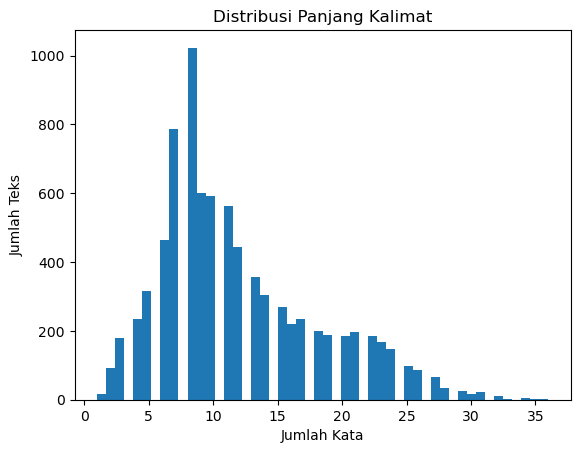

panjang max kalimat: 36


In [15]:
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 100))
print("panjang max kalimat:", MAX_LEN)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_processed'], df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 1    2699
 2    1990
 0    1149
 Name: count, dtype: int64,
 label_num
 1    1157
 2     853
 0     493
 Name: count, dtype: int64)

In [17]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train, maxlen=MAX_LEN, padding='post', truncating='post')
padded_test = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post', truncating='post')

In [55]:
padded_train

array([[   3,  505,  185, ...,    0,    0,    0],
       [   2,  160, 1297, ...,    0,    0,    0],
       [ 299,  815,    2, ...,    0,    0,    0],
       ...,
       [ 693,  984,   13, ...,    0,    0,    0],
       [  41,   10,  753, ...,    0,    0,    0],
       [1274, 2542,  278, ...,    0,    0,    0]])

# Model Architecture Definition

# Training Model

In [18]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([1149, 2699, 1990], dtype=int64))


In [19]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.6936466492602262, 1: 0.7210077806595035, 2: 0.9778894472361809}

In [20]:
import numpy as np
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', limit=50000)  # optional limit

embedding_dim = 300
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # fallback


In [21]:
# 1

from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model = Sequential()
model.add(Embedding(
    input_dim=MAX_WORDS,
    output_dim=embedding_dim,
    input_length=MAX_LEN,
    weights=[embedding_matrix],
    trainable=True
))

model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='models/best_model_LSTM.h5',         
    monitor='val_loss',               
    save_best_only=True,             
    mode='min',                      
    verbose=1                       
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)
history = model.fit(
    padded_train,
    y_train,
    epochs=100,
    validation_data=(padded_test, y_test),
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights  
)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 7.8750 - accuracy: 0.6430
Epoch 1: val_loss improved from inf to 1.61017, saving model to models\best_model_LSTM.h5
183/183 [==============================] - 19s 64ms/step - loss: 7.8750 - accuracy: 0.6430 - val_loss: 1.6102 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 2/100
182/183 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.7984
Epoch 2: val_loss improved from 1.61017 to 0.80113, saving model to models\best_model_LSTM.h5
183/183 [==============================] - 11s 61ms/step - loss: 0.8718 - accuracy: 0.7984 - val_loss: 0.8011 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 3/100
182/183 [============================>.] - ETA: 0s - loss: 0.6088 - accuracy: 0.8324
Epoch 3: val_loss improved from 0.80113 to 0.59977, saving model to models\best_model_LSTM.h5
183/183 [==============================] - 11s 62ms/step - loss: 0.6082 - accuracy: 0.8326 - val_loss: 0.5998 - val_accuracy: 0.8234 - lr: 

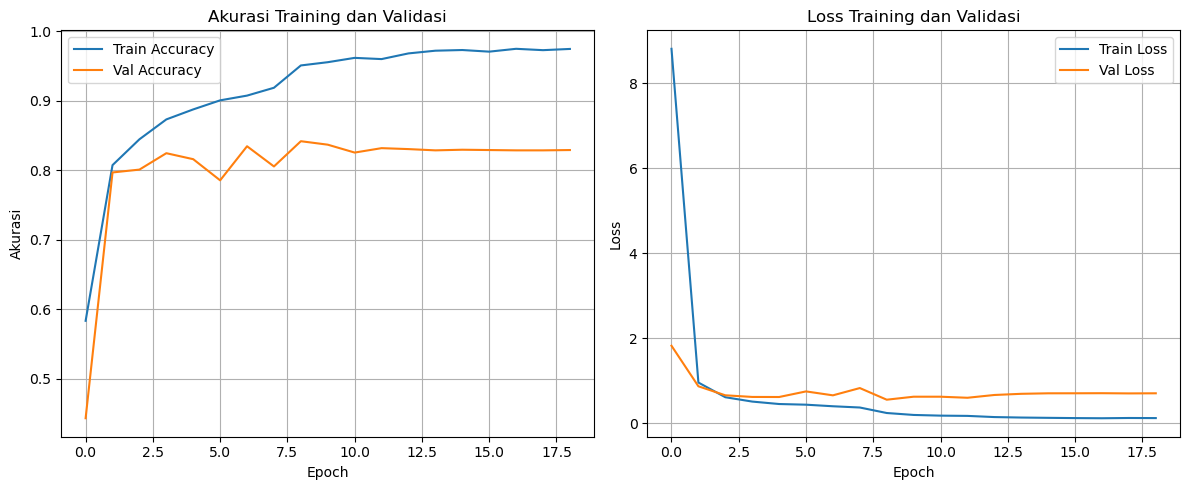

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


69/69 [==============================] - 4s 22ms/step


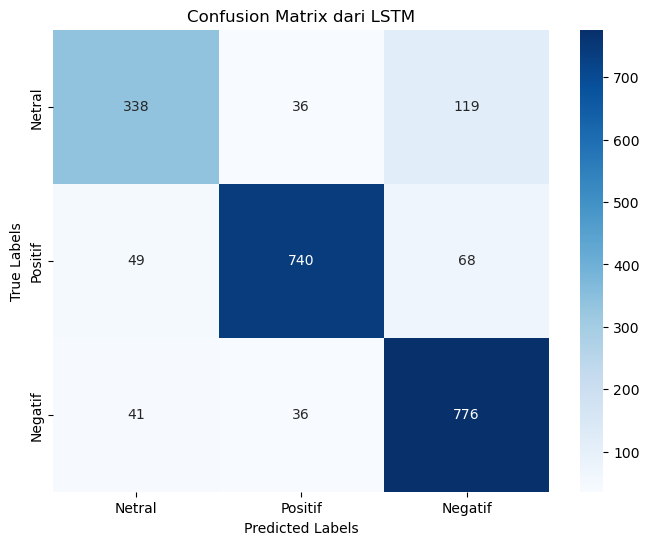

              precision    recall  f1-score   support

      Netral       0.79      0.69      0.73       493
     Positif       0.91      0.86      0.89       857
     Negatif       0.81      0.91      0.85       853

    accuracy                           0.84      2203
   macro avg       0.84      0.82      0.83      2203
weighted avg       0.84      0.84      0.84      2203



In [27]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model = load_model("models/best_model_LSTM.h5")

y_pred_probs = best_model.predict(padded_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari LSTM')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))


In [28]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model_GRU = load_model("models/best_model_GRU.h5")

y_pred_probs = best_model_GRU.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari GRU')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))


UnimplementedError: Graph execution error:

Detected at node 'sequential_2/Cast' defined at (most recent call last):
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\akmal\AppData\Local\Temp\ipykernel_15700\2003960547.py", line 9, in <module>
      y_pred_probs = best_model_GRU.predict(X_test)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
      result = self._call(*args, **kwds)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 963, in _call
      self._initialize(args, kwds, add_initializers_to=initializers)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 785, in _initialize
      self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\function.py", line 2523, in _get_concrete_function_internal_garbage_collected
      graph_function, _ = self._maybe_define_function(args, kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\function.py", line 2760, in _maybe_define_function
      graph_function = self._create_graph_function(args, kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\function.py", line 2670, in _create_graph_function
      func_graph_module.func_graph_from_py_func(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1247, in func_graph_from_py_func
      func_outputs = python_func(*func_args, **func_kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 677, in wrapped_fn
      out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1222, in autograph_handler
      return autograph.converted_call(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py", line 1315, in run
      return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py", line 2891, in call_for_each_replica
      return self._call_for_each_replica(fn, args, kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py", line 3692, in _call_for_each_replica
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\functional.py", line 649, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\keras\engine\functional.py", line 761, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\util\dispatch.py", line 1176, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1003, in cast
      x = gen_math_ops.cast(x, base_type, name=name)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2013, in cast
      _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 797, in _apply_op_helper
      op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\func_graph.py", line 735, in _create_op_internal
      return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\ops.py", line 3800, in _create_op_internal
      ret = Operation(
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\ops.py", line 2108, in __init__
      c_op = _create_c_op(g, node_def, inputs, control_input_ops, op_def=op_def)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\framework\ops.py", line 1974, in _create_c_op
      tf_stack.extract_stack_for_op(c_op, stacklevel=3)
    File "c:\Users\akmal\anaconda3\envs\keras_env\lib\site-packages\tensorflow\python\util\tf_stack.py", line 180, in extract_stack_for_op
      _tf_stack.extract_stack_for_op(
Node: 'sequential_2/Cast'
Cast string to float is not supported
	 [[{{node sequential_2/Cast}}]] [Op:__inference_predict_function_34093]

69/69 [==============================] - 7s 32ms/step


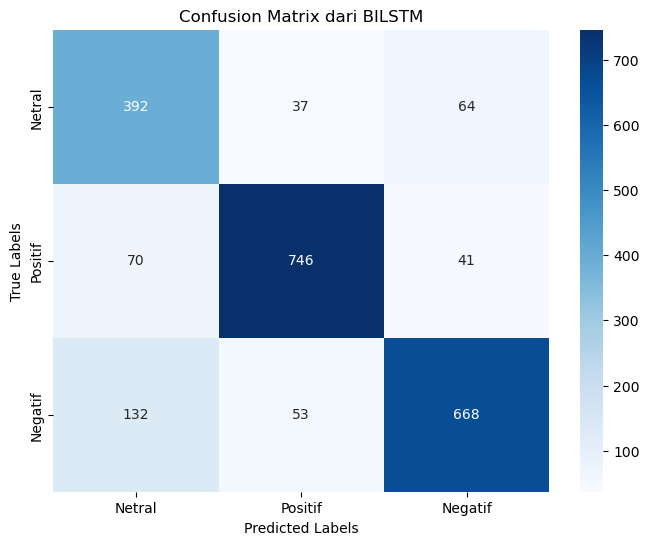

              precision    recall  f1-score   support

      Netral       0.66      0.80      0.72       493
     Positif       0.89      0.87      0.88       857
     Negatif       0.86      0.78      0.82       853

    accuracy                           0.82      2203
   macro avg       0.81      0.82      0.81      2203
weighted avg       0.83      0.82      0.82      2203



In [19]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model_BILSTM = load_model("models/best_model_BILSTM.h5")

y_pred_probs = best_model_BILSTM.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari BILSTM')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))


In [39]:
label_map = {0: "Netral", 1: "Positif", 2: "Negatif"}
best_model = load_model("models/best_model_LSTM.h5")

def predict_text(text):
    clean_text = preprocessing(text)
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    prediction = best_model.predict(padded)
    predicted_class = np.argmax(prediction)
    
    print(f"Teks: {text}")
    print(f"Prediksi Kelas: {predicted_class} → {label_map[predicted_class]}")

text = 'prabowo telah dilantik, ia akan menjadi presiden ke 8  ' 
predict_text(text)

1/1 [==============================] - 3s 3s/step
Teks: prabowo telah dilantik, ia akan menjadi presiden ke 8  
Prediksi Kelas: 0 → Netral
